Import Necessary libraries

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSCanonical
from scipy.linalg import svd, pinv2

# Data

In [2]:
X = np.array([
    [2.88,-0.35,-0.07,0.27],
    [-1.03, -0.13, -1.01, -0.45],
    [0.91,-0.97,1.08,-1.48],
    [0.79,-0.69,-0.32,1.42],
    [0.62,-1.11,0.65,0.13]
])
 
Y = np.array([
    [2.742, 2.966, 0.195, 3.061, 2.119],
    [-2.385, -6.058, -1.357, -1.829,-2.618],
    [-0.421,-3.631, 0.252, -0.703,-0.799],
    [0.989,4.085,0.279,1.698,-0.149],
    [0.251,0.84,0.865,0.545,-0.922]
])

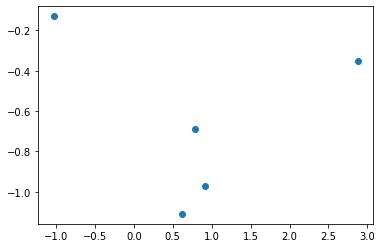

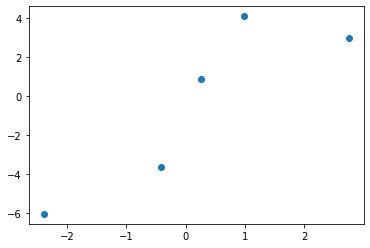

In [3]:
plt.scatter(X[:,0], X[:,1])
plt.show()
plt.scatter(Y[:,0], Y[:,1])
plt.show()

In [4]:
X_orig = X.copy()
 
print("X:\n", X, "\n Y:\n", Y, '\n\n')

X:
 [[ 2.88 -0.35 -0.07  0.27]
 [-1.03 -0.13 -1.01 -0.45]
 [ 0.91 -0.97  1.08 -1.48]
 [ 0.79 -0.69 -0.32  1.42]
 [ 0.62 -1.11  0.65  0.13]] 
 Y:
 [[ 2.742  2.966  0.195  3.061  2.119]
 [-2.385 -6.058 -1.357 -1.829 -2.618]
 [-0.421 -3.631  0.252 -0.703 -0.799]
 [ 0.989  4.085  0.279  1.698 -0.149]
 [ 0.251  0.84   0.865  0.545 -0.922]] 




# Function

In [5]:
def _svd_flip_1d(u, v):
    biggest_abs_val_idx = np.argmax(np.abs(u))
    sign = np.sign(u[biggest_abs_val_idx])
    u *= sign
    v *= sign
 
 
def _center_scale_xy(X, Y, scale=True):
    # center
    x_mean = X.mean(axis=0)
    X -= x_mean
    y_mean = Y.mean(axis=0)
    Y -= y_mean
    # scale
    if scale:
        x_std = X.std(axis=0, ddof=1)
        x_std[x_std == 0.0] = 1.0
        X /= x_std
        y_std = Y.std(axis=0, ddof=1)
        y_std[y_std == 0.0] = 1.0
        Y /= y_std
    else:
        x_std = np.ones(X.shape[1])
        y_std = np.ones(Y.shape[1])
    return X, Y, x_mean, y_mean, x_std, y_std

# PLS

In [6]:
n_components=1
n = X.shape[0]
p = X.shape[1]
q = Y.shape[1]
 
x_weights_ = np.zeros((p, n_components))  # U
y_weights_ = np.zeros((q, n_components))  # V
_x_scores = np.zeros((n, n_components))  # Xi
_y_scores = np.zeros((n, n_components))  # Omega
x_loadings_ = np.zeros((p, n_components))  # Gamma
y_loadings_ = np.zeros((q, n_components))  # Delta
n_iter_=[]
 
Xk, Yk, _x_mean, _y_mean, _x_std, _y_std = _center_scale_xy(X.copy(), Y.copy())
 
Y_eps=np.finfo(Yk.dtype).eps
max_iter=500
algorithm = 'svd'
deflation_mode = 'canonical'
mode = 'A'
tol=1e-6

In [7]:
n,p,q

(5, 4, 5)

In [8]:
if deflation_mode == 'canonical':
    rank_upper_bound = p
else:
    rank_upper_bound = min(n, p, q)
     
_norm_y_weights = (deflation_mode == 'canonical')  # 1.1
norm_y_weights = _norm_y_weights

In [9]:
for k in range(n_components):
    print('-'*50, k, '-'*50)
    ################################
    # Weights: uk, vk
    ################################
    C = np.dot(Xk.T, Yk)
    U, S, Vt = svd(C, full_matrices=False)
    # U --> Left singular values
    # S --> Singular values (diagonal)
    # V --> Right singular vectors
    # C = np.dot(U, np.dot(S*np.eye(4,4), Vt))
    print('\n')
    print('C:\n', C.round(2), '\n') # covariance
    print('U:\n', U.round(2), '\n') #  rotation
    print('S:\n', S.round(2), '\n') # stretches ... stores equivalent of lambda
    print('Vt:\n', Vt.round(2), '\n\n') #  rotation
     
     
    x_weights, y_weights =  U[:, 0], Vt[0, :] 
    print("np.dot(U[:, 0].T, U[:, 0]):", np.dot(U[:, 0].T, U[:, 0]).round(2), '\n')
    print("np.dot(Vt[0, :].T, Vt[0, :]):", np.dot(Vt[0, :].T, Vt[0, :]).round(2), '\n\n')
     
    _svd_flip_1d(x_weights, y_weights)
 
    ################################
    # Scores: eta_k, w_k
    ################################
    # compute scores, i.e. the projections of X and Y
    x_scores = np.dot(Xk, x_weights)   # eta_k
    if norm_y_weights:
        y_ss = 1
    else:
        y_ss = np.dot(y_weights, y_weights)
    y_scores = np.dot(Yk, y_weights) / y_ss  #w_k
 
     
    ################################
    # Loadings: gamma_k, delta_k
    ################################
    # Deflation: subtract rank-one approx to obtain Xk+1 and Yk+1
    print('-- matrix ---')
    print('Xk:\n', Xk, '\n')
     
    x_loadings = np.dot(x_scores, Xk) / np.dot(x_scores, x_scores)  #
    Xk -= np.outer(x_scores, x_loadings)
     
 
    print('np.outer(x_scores, x_loadings):\n', np.outer(x_scores, x_loadings), '\n')
    print('Xk (after substract):\n', Xk )
    print('------','\n\n')
     
 
    if deflation_mode == "canonical":
        # regress Yk on y_score
        y_loadings = np.dot(y_scores, Yk) / np.dot(y_scores, y_scores)
        Yk -= np.outer(y_scores, y_loadings)  # np.outer() is same as .T i.e. transpose
    if deflation_mode == "regression":
        # regress Yk on x_score
        y_loadings = np.dot(x_scores, Yk) / np.dot(x_scores, x_scores)
        Yk -= np.outer(x_scores, y_loadings)
 
    x_weights_[:, k] = x_weights # uk
    y_weights_[:, k] = y_weights # vk
    _x_scores[:, k] = x_scores   # epsilon_k
    _y_scores[:, k] = y_scores   # w_k
    x_loadings_[:, k] = x_loadings # gamma_k
    y_loadings_[:, k] = y_loadings # delta_k
 
    print("x_weights_:\n", x_weights_, '\n')
    print("y_weights_:\n", y_weights_, '\n')   
    print("_x_scores:\n", _x_scores, '\n' )
    print("_y_scores:\n", _y_scores, '\n' )
    print("x_loadings_:\n", x_loadings_, '\n' )
    print("y_loadings_:\n", y_loadings_, '\n' )
     
    # Compute transformation matrices (rotations_). See User Guide.
    x_rotations_ = np.dot(
        x_weights_,
        pinv2(np.dot(x_loadings_.T, x_weights_),check_finite=False))
     
    y_rotations_ = np.dot(
        y_weights_, pinv2(np.dot(y_loadings_.T, y_weights_),check_finite=False))
 
    coef_ = np.dot(x_rotations_, y_loadings_.T)
    coef_ = coef_ * _y_std
    
    print('\ncoef_:\n', coef_,'\n')
    print('Xk:\n', Xk, '\n')
    print("Yk:\n", Yk, '\n')
     

-------------------------------------------------- 0 --------------------------------------------------


C:
 [[ 3.8   2.77  2.38  3.52  3.93]
 [-0.57 -0.92 -3.33 -0.16 -0.06]
 [ 0.99  0.38  3.06  0.32  0.88]
 [ 1.96  3.21  0.91  2.56  1.4 ]] 

U:
 [[ 0.8   0.22 -0.5   0.26]
 [-0.24  0.7  -0.36 -0.56]
 [ 0.27 -0.6  -0.21 -0.72]
 [ 0.49  0.31  0.76 -0.3 ]] 

S:
 [9.25 3.78 1.74 0.01] 

Vt:
 [[ 0.47  0.44  0.43  0.45  0.44]
 [ 0.12  0.2  -0.89  0.34  0.19]
 [-0.24  0.74  0.03  0.1  -0.61]
 [ 0.08 -0.46  0.09  0.74 -0.47]] 


np.dot(U[:, 0].T, U[:, 0]): 1.0 

np.dot(Vt[0, :].T, Vt[0, :]): 1.0 


-- matrix ---
Xk:
 [[ 1.47330421  0.72975638 -0.16570217  0.27540185]
 [-1.34224782  1.26491106 -1.31099659 -0.40367121]
 [ 0.05472684 -0.77840681  1.23545589 -1.37512294]
 [-0.03168396 -0.09730085 -0.47030175  1.36003243]
 [-0.15409927 -1.11895979  0.71154462  0.14335987]] 

np.outer(x_scores, x_loadings):
 [[ 0.8379257  -0.41891981  0.45663276  0.41189286]
 [-1.47398529  0.73691695 -0.80325735 -

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:82: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead


# PLSCanonical

In [10]:

print('='*25)
plsca = PLSCanonical(n_components=2, algorithm=algorithm, scale=True)
plsca.fit(X,Y)
 
print("PLSCanonical: x_weights:\n", plsca.x_weights_, '\n')
print("Calculated: x_weights_:\n", x_weights_, '\n')

PLSCanonical: x_weights:
 [[ 0.79639603  0.22436662]
 [-0.23755967  0.70787937]
 [ 0.26769172 -0.59593871]
 [ 0.48750375  0.30565253]] 

Calculated: x_weights_:
 [[ 0.79639603]
 [-0.23755967]
 [ 0.26769172]
 [ 0.48750375]] 

